In [ ]:
# Outpatient Appointments No-Show Prediction and Analysis
# ==============================================
# Goal: Predict whether a patient will show up for their outpatient appointment based on various features and analyze the factors influencing no-shows.
# Output: A predictive model and insights into factors affecting appointment attendance.Evaluate model performance using accuracy, precision, recall, and F1-score metrics.

In [64]:
# Install required packages
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, RocCurveDisplay, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression

In [3]:
# Load Appointment dataset
df = pd.read_csv(r'C:\Users\darry\Data Analysis ML Project Portfolio\Appointment No-Show Rate Proj 1 v2\Data\noshows.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.shape

(110527, 14)

In [6]:
# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]
df.columns

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no_show'],
      dtype='object')

In [ ]:
# Define Outcome Target: 'no_show' (Yes/No)
df['no_show'] = (df['no_show'].str.lower() == 'yes').astype(int)

baseline_no_show_rate = df['no_show'].mean()
print(f"Baseline No-Show Rate:", baseline_no_show_rate)    

Baseline No-Show Rate: 0.20193255946510807


In [11]:
# Convert date comlumns to datetime
df['appointmentday'] = pd.to_datetime(df['appointmentday'], errors='coerce', utc=True)
df['scheduledday'] = pd.to_datetime(df['scheduledday'], errors='coerce', utc=True)

In [ ]:
# Create lead time and appointment day of the week features
df['lead_time_days'] = (df['appointmentday'] - df['scheduledday']).dt.days # Days between scheduling and appointment
df['lead_time_days'] = df['lead_time_days'].clip(lower=0)  # Ensure no negative lead times


df['appointment_dayofweek'] = df['appointmentday'].dt.dayofweek # Monday=0, Sunday=6

df[['appointmentday', 'scheduledday', 'lead_time_days', 'appointment_dayofweek']].head()

,appointmentday,scheduledday,lead_time_days,appointment_dayofweek
0,2016-04-29 00:00:00+00:00,2016-04-29 18:38:08+00:00,0,4
1,2016-04-29 00:00:00+00:00,2016-04-29 16:08:27+00:00,0,4
2,2016-04-29 00:00:00+00:00,2016-04-29 16:19:04+00:00,0,4
3,2016-04-29 00:00:00+00:00,2016-04-29 17:29:31+00:00,0,4
4,2016-04-29 00:00:00+00:00,2016-04-29 16:07:23+00:00,0,4


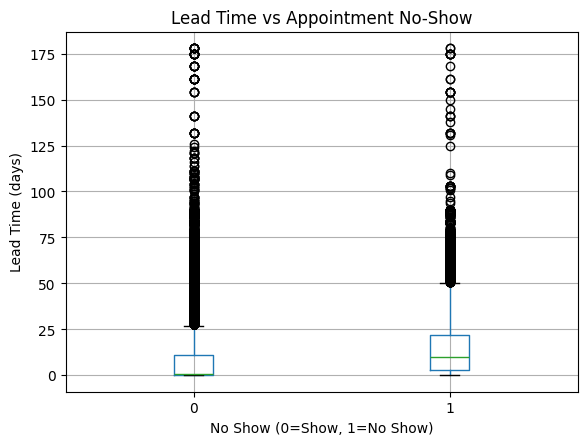

In [65]:
# Create lead_time_days vs no_show boxplot

df.boxplot(column='lead_time_days', by='no_show')
plt.title('Lead Time vs Appointment No-Show')
plt.suptitle('')
plt.xlabel('No Show (0=Show, 1=No Show)')
plt.ylabel('Lead Time (days)')
plt.show()

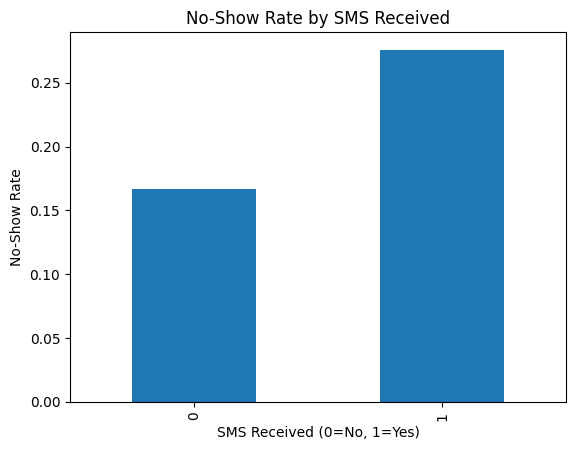

In [26]:
# Explore SMS_received vs no_show rates
sms_no_show_rates = df.groupby('sms_received')['no_show'].mean()
sms_no_show_rates.plot(kind='bar')
plt.title('No-Show Rate by SMS Received')
plt.xlabel('SMS Received (0=No, 1=Yes)')
plt.ylabel('No-Show Rate')
plt.show()

In [50]:
df.groupby("sms_received")["lead_time_days"].median()

sms_received
0     0.0
1    13.0
Name: lead_time_days, dtype: float64

In [ ]:
# Create modeling pipeline to handle data preprocessing and model training (I.e., missing values, categorical encoding, scaling, etc.)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Define feature columns
feature_cols = ['lead_time_days',
                 'sms_received', 
                 'appointment_dayofweek']

# Preprocessing for numeric features
numeric_features = ['lead_time_days']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))
    ('scaler', StandardScaler()) ])

# Preprocessing for categorical features
categorical_features = ['sms_received', 'appointment_dayofweek']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most frequent'))
    ('onehot', OneHotEncoder(handle_unknown='ignore')) ])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features) ])

# Create modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
# Split data into training and test sets
X = df[feature_cols]
y = df['no_show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

              precision    recall  f1-score   support

        Show       0.80      0.99      0.89     17642
     No-Show       0.32      0.01      0.03      4464

    accuracy                           0.80     22106
   macro avg       0.56      0.50      0.46     22106
weighted avg       0.70      0.80      0.71     22106

ROC AUC Score: 0.6698
Baseline No-Show Rate: 0.20193255946510807


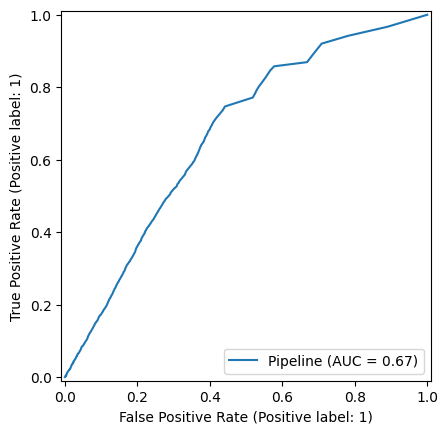

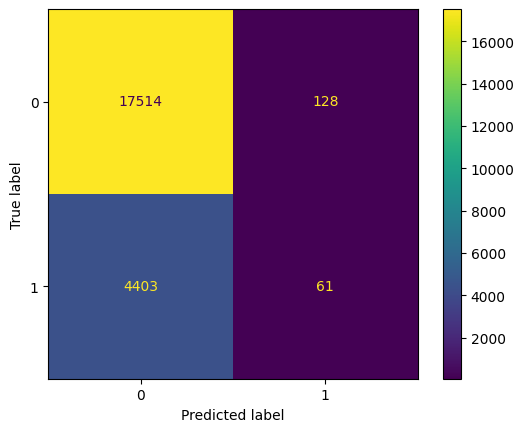

In [30]:
# Train the model
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate model performance
print(classification_report(y_test, y_pred, target_names=['Show', 'No-Show']))
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")
RocCurveDisplay.from_estimator(model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
# Outcome Target: 'no_show' (Yes/No)
baseline_no_show_rate = df['no_show'].mean()
print(f"Baseline No-Show Rate:", baseline_no_show_rate)

In [ ]:
# Predict appointment no-show risk
risk = model.predict_proba(X_test)[:, 1]
results = X_test.copy()
results["risk"] = risk
results["actual_no_show"] = y_test.values
results.head()


,lead_time_days,sms_received,appointment_dayofweek,risk,actual_no_show
23937,0,0,0,0.150822,1
99403,26,1,2,0.297304,0
100162,13,1,4,0.272047,0
63869,4,1,1,0.210384,1
7668,0,0,4,0.163378,0


In [ ]:
# Create threshold-based no-show predictions for high-risk appointments
threshold = results['risk'].quantile(0.8)  # Top 20% risk threshold
results['predicted_no_show'] = (results['risk'] >= threshold).astype(int)

high_risk_appointments = results[results['risk'] >= threshold]
low_risk_appointments = results[results['risk'] < threshold]

high_risk_appointments.shape, low_risk_appointments.shape



((4473, 6), (17633, 6))

In [ ]:
# Compare no-show rates in high-risk vs low-risk groups
baseline_no_show_rate = df['no_show'].mean()
high_risk_appointments_no_show_rate = high_risk_appointments['actual_no_show'].mean()
low_risk_appointments_no_show_rate = low_risk_appointments['actual_no_show'].mean()

baseline_no_show_rate, high_risk_appointments_no_show_rate, low_risk_appointments_no_show_rate

(np.float64(0.20193255946510807),
 np.float64(0.3123183545718757),
 np.float64(0.17393523507060624))